## Curve fiting of proteins by dose 

In order to start plotting the curves, we made some modifications to the dose values:  

- we transformed the doses to a logarithmic scale: `dose_log <- log10(dose)`  
- we set the dose spacing to 1: `dose_spacing = 1`  
- we shifted the dose values to ensure all were positive:  
  `dose_shift = abs(min(dose_log)) + dose_spacing`  
- finally, we applied the shift: `dose_log_shifted <- dose_log + dose_shift`  

We then used the **fastbmdR** package on our **norm_signal** data, after filtering out proteins that had 100% missing values.

In [50]:
#
library(ggplot2)

#install.packages("drc", dependencies = TRUE)

devtools::install_github("jessica-ewald/fastbmdR")


Using GitHub PAT from the git credential store.

Skipping install of 'fastbmdR' from a github remote, the SHA1 (b3681861) has not changed since last install.
  Use `force = TRUE` to force installation



In [51]:
library(fastbmdR)
library(dplyr)
library(knitr)

In [148]:
## computing the BMD for the proteiomic data

#df <- read.csv("../00.exploratory_analysis/outputs/df_CC_Proba.csv", sep = ",")

df <- read.csv("../00.exploratory_analysis/outputs/norm_signal_filtered.csv", sep= ',')

df <- df[df$Metadata_Categories != "JUMP Control", ]
df <- df[df$Metadata_Compound != "UNTREATED", ]

models <- c("Exp2", "Exp3", "Exp4", "Exp5", "Poly2", "Lin", "Power", "Hill")

ncpus <- 1  

unique_compounds <- unique(df$Metadata_Compound)

feat_cols = colnames(df)[!grepl("Metadata", colnames(df))]
res = list()
gene_table <- list()

all_bmd_pass <- data.frame()

for (compound in unique_compounds) {
  
  compound_data <- df[df$Metadata_Compound %in% c(compound, "DMSO"), ]
  
  dose <- compound_data$Metadata_Concentration
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose = unique(dose) %>% sort(. , decreasing = TRUE)
  dose_spacing = abs(log10(rank_dose[2]/rank_dose[1]))
  
  dose_shift = abs(min(dose_log)) + dose_spacing
  dose_shifted = dose_log
  dose_shifted[dose_shifted != 0] = dose_shifted[dose_shifted != 0] + dose_shift
  
  if (length(unique(compound_data$Metadata_Concentration)) > 2) {  
    
    print(paste("Processing compound:", compound))  
    dose <- dose_shifted
    
    compound_mat <- t(compound_data[, feat_cols])  
    min_val = abs(min(compound_mat, na.rm=TRUE))  
    add_min = min_val + 0.1 * min_val  
    mat_new = compound_mat + add_min  
    
    if (length(dose) == ncol(mat_new)) {  
      tryCatch({
        fit_obj <- PerformCurveFitting(data = mat_new, dose = dose, ncpus = ncpus, models = models)
        fit_obj <- FilterDRFit(fit_obj, lof.pval = 0.1, filt.var = "AIC.model")
        fit_obj <- PerformBMDCalc(fit_obj, ncpus = ncpus, num.sds = 2, bmr.method = "sample.mean", log10.dose = TRUE)
        
        bmd_res <- fit_obj$bmd_res
        bmd_pass <- bmd_res[bmd_res$all.pass, ]
        fit_obj$bmd_pass <- bmd_pass

        res[[compound]] = fit_obj
        
        if (nrow(bmd_pass) > 0) {
          bmd_pass$compound_name <- compound
          all_bmd_pass <- rbind(all_bmd_pass, bmd_pass) 
        }
      }, error = function(e) {
        print(paste("Error with compound:", compound, "- ignoring this compound"))
      })
    }
  }  
}




[1] "Processing compound: Actinomycin D"
[1] "Processing compound: Bevirimat"
[1] "Processing compound: Ethoxyquin"
[1] "Processing compound: Amperozide"
[1] "Processing compound: IOPANOIC ACID"
[1] "Processing compound: Treprostinil"
[1] "Processing compound: MILTEFOSINE"
[1] "Processing compound: Lys05"
[1] "Processing compound: 5,8,11-Eicosatriynoic acid"
[1] "Processing compound: Cycloheximide"
[1] "Processing compound: CLIOQUINOL"
[1] "Processing compound: Berberine chloride"
[1] "Processing compound: Rifampicin"
[1] "Processing compound: Cucurbitacin I"
[1] "Processing compound: Triamcinolone acetonide"
[1] "Processing compound: Imiquimod"
[1] "Processing compound: MUPIROCIN"
[1] "Processing compound: Nedocromil (sodium salt)"
[1] "Processing compound: Staurosporine"
[1] "Processing compound: Cladribine"
[1] "Processing compound: 5,6-benzoflavone"
[1] "Processing compound: Natamycin"
[1] "Processing compound: FCCP"
[1] "Processing compound: PEMIROLAST POTASSIUM"
[1] "Processing c

In [141]:
#write.csv(all_bmd_pass, "/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/01.dose_response/outputs/bmd_pass_protein.csv", row.names = FALSE)


## load the BMD results

all_bmd_pass <- read.csv("./outputs/bmd_pass_protein.csv", sep = ",")

In [149]:
print(all_bmd_pass)

      gene.id mod.name             b             c             d         e  f
1      O00175     Exp3  -0.151617938            NA  4.547309e+00 0.1882725 NA
2      O00220     Exp3   0.154557438            NA  3.878414e+00 0.1889344 NA
4      O14625     Exp3  -0.181769483            NA  1.245348e+01 0.1879731 NA
5      O14672     Exp3   0.173311521            NA  1.169455e+01 0.1935234 NA
6      O14836     Exp3   0.159881389            NA  6.562216e+00 0.1869662 NA
7      O15467     Hill  15.633130447  3.131226e-02  2.097627e-01 4.2862930 NA
8      O43508    Poly2   0.185592468 -1.324445e-03  8.813085e-04        NA NA
13     O75144     Exp3   0.179335557            NA  8.052277e+00 0.1873809 NA
14     O75509    Poly2   0.197996529 -1.770448e-02  3.776289e-03        NA NA
15     O75888     Exp3   0.213255068            NA  4.576699e+00 0.2241727 NA
20     O95760     Exp3   0.139931166            NA  6.269016e+00 0.1881766 NA
21     P00533     Exp3   0.090069865            NA  2.652374e+00

In [150]:
## calculating the bmd values at real concentration

all_bmd_pass$Concentration <- NA
all_bmd_pass$Concentration_L <- NA
all_bmd_pass$Concentration_U <- NA

for (i in 1:nrow(all_bmd_pass)) {
  compound <- all_bmd_pass$compound_name[i]
  bmd <- all_bmd_pass$bmd[i]
  bmdl <- all_bmd_pass$bmdl[i]
  bmdu <- all_bmd_pass$bmdu[i]
  
  compound_data <- df[df$Metadata_Compound == compound, ]
  dose <- compound_data$Metadata_Concentration
  
  # Transformer en log10 (en évitant les zéros)
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose <- unique(dose)
  rank_dose <- sort(rank_dose, decreasing = TRUE)
  
  # Saut entre deux concentrations successives (log-échelle)
  if (length(rank_dose) > 1) {
    dose_spacing <- abs(log10(rank_dose[2] / rank_dose[1]))
  } else {
    dose_spacing <- 1  # Valeur arbitraire s'il n'y a qu'une concentration
  }
  
  dose_shift <- abs(min(dose_log, na.rm = TRUE)) + dose_spacing
  
  all_bmd_pass$Concentration[i] <- 10^(bmd - dose_shift)
  all_bmd_pass$Concentration_L[i] <- 10^(bmdl - dose_shift)
  all_bmd_pass$Concentration_U[i] <- 10^(bmdu - dose_shift)
}



In [151]:
# Count the frequency of each protein

library(dplyr)

compound_count_per_protein <- all_bmd_pass %>%
  group_by(gene.id) %>%
  summarise(n_compounds = n_distinct(compound_name)) %>%
  arrange(desc(n_compounds))


print(compound_count_per_protein)



# A tibble: 168 x 2
   gene.id n_compounds
   <chr>         <int>
 1 Q14393           16
 2 P09341           14
 3 Q9H2A7           14
 4 P0DJI8           13
 5 Q12805           13
 6 Q15113           13
 7 Q16610           13
 8 Q9BY76           13
 9 P09237           12
10 P13500           12
# i 158 more rows


In [152]:
list_plot <- list()  

for (i in 1:nrow(all_bmd_pass)) {  
  tryCatch({
    gene_id <- all_bmd_pass$gene.id[i]
    compound <- all_bmd_pass$compound_name[i]
    
    temp <- plot_bmd_curve(gene_id, res[[compound]], return_type = "plot.data")
    
    temp$protein <- gene_id
    temp$compound <- compound
    temp$category <- all_bmd_pass$Metadata_Categories[i]
    temp$bmd <- all_bmd_pass$bmd[i]
    temp$bmd_l <- all_bmd_pass$bmdl[i]
    temp$bmd_u <- all_bmd_pass$bmdu[i]
    temp$Concentration <- all_bmd_pass$Concentration[i]
    
    list_plot[[i]] <- temp
  }, error = function(e) {
    message(sprintf("Error for gene_id %s and compound %s : %s", gene_id, compound, e$message))
  })
}

final_df <- do.call(rbind, list_plot)

# Aperçu des résultats
kable(head(final_df))



|  x| Observations|       f_x|protein |compound      |      bmd|    bmd_l|   bmd_u| Concentration|
|--:|------------:|---------:|:-------|:-------------|--------:|--------:|-------:|-------------:|
|  0|    0.1879041| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1960699| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.2082702| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1722449| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1719874| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1936951| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|

In [153]:
print(head(final_df))

  x Observations       f_x protein      compound      bmd    bmd_l    bmd_u
1 0    0.1879041 0.1882725  O00175 Actinomycin D 4.345116 4.243573 4.437511
2 0    0.1960699 0.1882725  O00175 Actinomycin D 4.345116 4.243573 4.437511
3 0    0.2082702 0.1882725  O00175 Actinomycin D 4.345116 4.243573 4.437511
4 0    0.1722449 0.1882725  O00175 Actinomycin D 4.345116 4.243573 4.437511
5 0    0.1719874 0.1882725  O00175 Actinomycin D 4.345116 4.243573 4.437511
6 0    0.1936951 0.1882725  O00175 Actinomycin D 4.345116 4.243573 4.437511
  Concentration
1      110.6843
2      110.6843
3      110.6843
4      110.6843
5      110.6843
6      110.6843


In [ ]:
## we now plot the bmd curves for each compound and protein and save them in a pdf file

library(ggplot2)
library(ggforce)


n_per_page <- 9  


final_df$compound_protein <- paste(final_df$compound, final_df$protein, sep = " - ")


plot_groups <- unique(final_df$compound_protein)
n_pages <- ceiling(length(plot_groups) / n_per_page)


pdf_file <- "./outputs/bmd_curves.pdf"
pdf(pdf_file, width = 15, height = 10)

for (i in 1:n_pages) {
  tryCatch({
    p <- ggplot(final_df, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +

      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      facet_wrap_paginate(~ compound_protein, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      
      labs(title = sprintf("BMD curves", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}
dev.off()


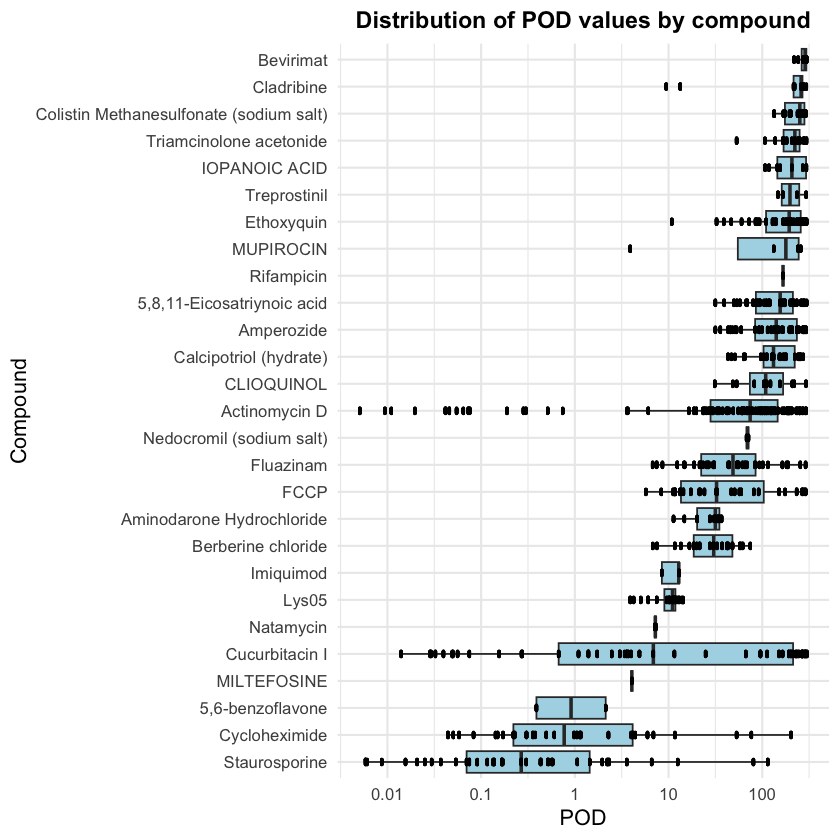

In [177]:
# boxplot of the BMD value per compound

library(ggplot2)

df_bmd <- final_df[!is.na(final_df$Concentration), ]


compound_order <- df_bmd %>%
  group_by(compound) %>%
  summarise(median_bmd = median(Concentration, na.rm = TRUE)) %>%
  arrange(median_bmd) %>%
  pull(compound)


df_bmd$compound <- factor(df_bmd$compound, levels = compound_order)


ggplot(df_bmd, aes(x = log10(Concentration), y = compound)) +
  geom_boxplot(fill = "lightblue", outlier.shape = NA, width = 0.8) +
  geom_jitter(width = 0, height = 0.1, alpha = 0.3, color = "black", size = 0.3) +
  labs(
    title = "Distribution of POD values by compound",
    x = "POD",
    y = "Compound"
  ) +
  scale_x_continuous(
    breaks = log10(c(0.001, 0.01, 0.1, 1, 10, 100)),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  theme_minimal(base_size = 13) +
  theme(
    axis.text.y = element_text(size = 10),
    axis.text.x = element_text(size = 10),
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold")
  )




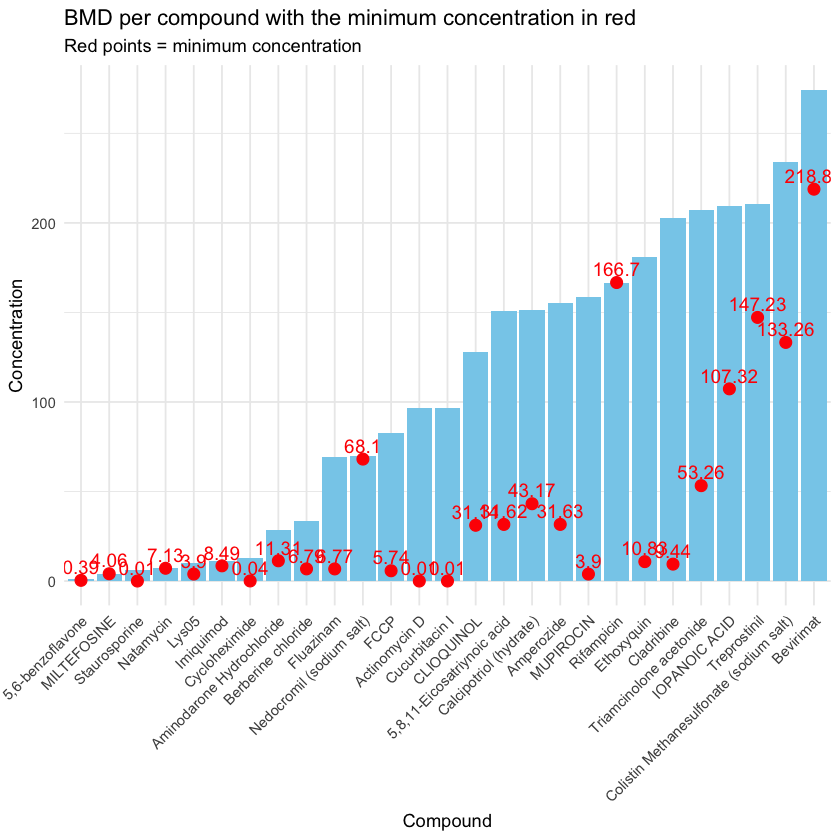

In [156]:
## Calculate the mean concentration for each compound

compound_categories <- df %>%
  select(Metadata_Compound, Metadata_Categories) %>%
  distinct() %>%
  rename(compound = Metadata_Compound, category_df = Metadata_Categories)

compound_summary <- final_df %>%
  group_by(compound) %>%
  summarise(
    mean_concentration = mean(Concentration, na.rm = TRUE),  
    min_concentration = min(Concentration, na.rm = TRUE),   
    nb_proteins = n_distinct(protein)
  ) %>%
  left_join(compound_categories, by = "compound")


p <- ggplot(compound_summary, aes(x = reorder(compound, mean_concentration), y = mean_concentration)) +
  geom_col(fill = "skyblue") + 
  geom_point(aes(y = min_concentration), color = "red", size = 3) +  
  geom_text(aes(y = min_concentration, label = round(min_concentration, 2)), 
            color = "red", vjust = -0.5, size = 4) + 
  #geom_text(aes(label = nb_proteins, y = mean_concentration + 5), size = 5, vjust = 0) +
  labs(title = "BMD per compound with the minimum concentration in red",
       x = "Compound",
       y = "Concentration",
       subtitle = "Red points = minimum concentration") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

print(p)


In [157]:
print(compound_summary)

# A tibble: 27 x 5
   compound         mean_concentration min_concentration nb_proteins category_df
   <chr>                         <dbl>             <dbl>       <int> <chr>      
 1 5,6-benzoflavone               1.26           0.389             2 Positive C~
 2 5,8,11-Eicosatr~             151.            31.6              33 Positive C~
 3 Actinomycin D                 96.8            0.00507         112 Positive C~
 4 Aminodarone Hyd~              28.2           11.3              11 Positive C~
 5 Amperozide                   155.            31.6              46 Positive C~
 6 Berberine chlor~              33.5            6.79             23 Positive C~
 7 Bevirimat                    274.           219.                8 Negative C~
 8 CLIOQUINOL                   128.            31.1              12 Negative C~
 9 Calcipotriol (h~             151.            43.2              25 Negative C~
10 Cladribine                   203.             9.44              9 Positive C~
# i 17 mo

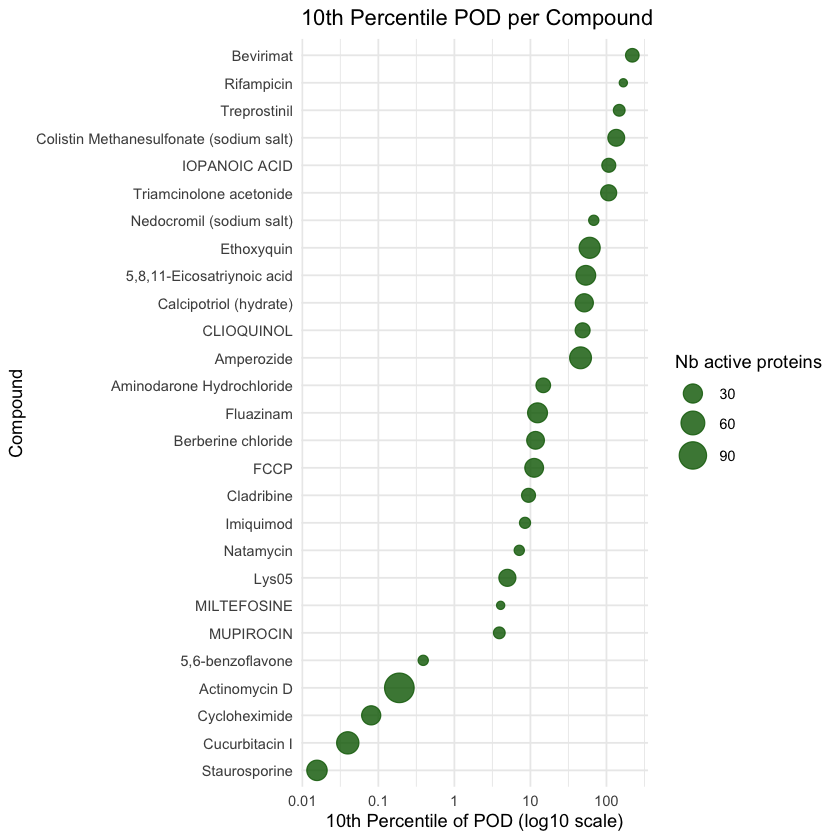

In [176]:
### Calculate the 10th percentile of BMD for each compound across all protein bmds 

pod_summary <- final_df %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein)
  ) %>%
  arrange(pod_10th_percentile)

#print(pod_summary, n=Inf)

ggplot(pod_summary, aes(x = pod_10th_percentile, y = reorder(compound, pod_10th_percentile))) +
  geom_point(aes(size = nb_proteins), color = "darkgreen", alpha = 0.8) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.001, 0.01, 0.1, 1, 10, 100),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  scale_size_continuous(range = c(2, 8)) +  # ajuste la taille des points ici
  labs(title = "10th Percentile POD per Compound",
       x = "10th Percentile of POD (log10 scale)",
       y = "Compound",
       size = "Nb active proteins") +
  theme_minimal()



In [ ]:
#write.csv(compound_summary, "/Users/grigoryanmariam/Downloads/proteomic_bmd_dose_results.csv", row.names = FALSE)


## Cell Count From CP data

We add the count cell columns from CP data to the proteomic data according to the plate number and compound well. 

In [108]:
library(arrow)
library(dplyr)

raw_data <- read_parquet("../00.exploratory_analysis/CP_data/raw.parquet")

raw_data <- raw_data %>% 
  filter(Metadata_BROAD_ID != "EMPTY")


raw_data <- raw_data %>%
  mutate(
    `Metadata_Compound Name` = ifelse(Metadata_BROAD_ID == "DMSO", "DMSO", `Metadata_Compound Name`),
    Metadata_Annotation = ifelse(Metadata_BROAD_ID == "DMSO", "DMSO", Metadata_Annotation),
    `Metadata_Compound Name` = ifelse(Metadata_BROAD_ID == "EMPTY", "EMPTY", `Metadata_Compound Name`),
    Metadata_Annotation = ifelse(Metadata_BROAD_ID == "EMPTY", "no treatment", Metadata_Annotation)
  )

selected_data <- raw_data %>%
  select('Metadata_Well', 'Metadata_Count_Cells', 'Metadata_plate_map_name')


In [109]:
# we add the cell count from CP data to Proteiomic imputed data + the probability of the RF classification

## all done no need to re-run this code just read the data df_CC_Proba.csv


df <- read.csv("../00.exploratory_analysis/outputs/norm_signal_filtered.csv", sep= ',')

df_pred <- read.csv("./outputs/df_pred.csv", sep= ',')


df <- df %>%
  mutate(Metadata_plate_map_name = case_when(
    Metadata_Plate == "BR00145683" ~ "BR00145695",
    Metadata_Plate == "BR00145686" ~ "BR00145692",
    TRUE ~ Metadata_Plate 
  ))


df <- df %>%
  left_join(selected_data, 
            by = c("Metadata_Well" = "Metadata_Well", 
                   "Metadata_plate_map_name" = "Metadata_plate_map_name"))


df <- merge(df, df_pred[, c("Metadata_Well", "Metadata_plate_map_name", "Probability")], 
            by = c("Metadata_Well", "Metadata_plate_map_name"),
            all.x = TRUE)

# Replacing the missing values probability with 0 from Jump controls and DMSO

df$Probability[is.na(df$Probability)] <- 0

sum(is.na(df$Probability))

#write.csv(df, file = "./outputs/df_CC_Proba.csv", row.names = FALSE)

[1] 0

In [110]:
#df <- read.csv("./outputs/df_CC_Proba.csv", sep= ',')


# we keep only the columns of interest

df_cc <- df[, c("Metadata_Compound", 'Probability', "Metadata_Concentration", "Metadata_Count_Cells")]


df_cc <- df_cc[df_cc$Metadata_Compound != "UNTREATED", ]


df_cc <- df_cc %>%
  rename(
    CC0 = Metadata_Count_Cells,
    RF_prob= Probability
  )


print(head(df_cc))


          Metadata_Compound RF_prob Metadata_Concentration  CC0
1                 LY2109761    0.00                  5.100 1570
3                Cladribine    0.63                  1.235 3059
4             Actinomycin D    0.55                300.000 1914
5              Treprostinil    0.50                  3.704 3355
6                 Bevirimat    0.50                  3.704 4112
7 Aminodarone Hydrochloride    0.46                  0.154 3784


In [111]:
print(feat_cols)

[1] "RF_prob" "CC0"    


In [115]:
models <- c("Exp2", "Exp3", "Exp4", "Exp5", "Poly2", "Lin", "Power", "Hill")

ncpus <- 1  

unique_compounds <- unique(df_cc$Metadata_Compound)

feat_cols = colnames(df_cc)[!grepl("Metadata", colnames(df_cc))]
res = list()
gene_table <- list()

bmd_list <- list()

for (compound in unique_compounds) {
  
  compound_data <- df_cc[df_cc$Metadata_Compound %in% c(compound, "DMSO"), ]
  
  dose <- compound_data$Metadata_Concentration
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose = unique(dose) %>% sort(. , decreasing = TRUE)
  dose_spacing = abs(log10(rank_dose[2]/rank_dose[1]))
  
  dose_shift = abs(min(dose_log)) + dose_spacing
  dose_shifted = dose_log
  dose_shifted[dose_shifted != 0] = dose_shifted[dose_shifted != 0] + dose_shift
  
  if (length(unique(compound_data$Metadata_Concentration)) > 2) {  
    
    print(paste("Processing compound:", compound))  
    dose <- dose_shifted
    
    compound_mat <- t(compound_data[, feat_cols])
    min_val = abs(min(compound_mat, na.rm=TRUE))  
    add_min = min_val + 0.1 * min_val  
    mat_new = compound_mat + add_min  
    
    if (length(dose) == ncol(mat_new)) {  
      tryCatch({
        fit_obj <- PerformCurveFitting(data = mat_new, dose = dose, ncpus = ncpus, models = models)
        fit_obj <- FilterDRFit(fit_obj, lof.pval = 0.1, filt.var = "AIC.model")
        #curve_obj <- FilterDRFit(fit_obj, lof.pval = 0, filt.var = "AIC.model")
        #extracting gene_id from curve_obj
  
        fit_obj <- PerformBMDCalc(fit_obj, ncpus = ncpus, num.sds = 2, bmr.method = "sample.mean", log10.dose = TRUE)
        # but the / bmd /bmdl / bmdu from fit_obj
        
        bmd_res <- fit_obj$bmd_res
        bmd_pass <- bmd_res[bmd_res$all.pass, ]
        fit_obj$bmd_pass <- bmd_pass

        res[[compound]] = fit_obj
        
        if (nrow(bmd_pass) > 0) {
          bmd_pass$compound_name <- compound
          bmd_list[[compound]] <- bmd_pass
        }
      }, error = function(e) {
        print(paste("Error with compound:", compound, "- ignoring this compound"))
      })
    }
  }
}

# Concaténation finale
all_bmd_pass <- do.call(rbind, bmd_list)


[1] "Processing compound: Cladribine"
[1] "Processing compound: Actinomycin D"
[1] "Processing compound: Treprostinil"
[1] "Processing compound: Bevirimat"
[1] "Processing compound: Aminodarone Hydrochloride"
[1] "Processing compound: Ethoxyquin"
[1] "Processing compound: MUPIROCIN"
[1] "Processing compound: Staurosporine"
[1] "Processing compound: Amperozide"
[1] "Processing compound: 5,8,11-Eicosatriynoic acid"
[1] "Processing compound: Lys05"
[1] "Processing compound: IOPANOIC ACID"
[1] "Processing compound: MILTEFOSINE"
[1] "Processing compound: Nedocromil (sodium salt)"
[1] "Processing compound: Rifampicin"
[1] "Processing compound: Cycloheximide"
[1] "Processing compound: CLIOQUINOL"
[1] "Processing compound: Berberine chloride"
[1] "Processing compound: Triamcinolone acetonide"
[1] "Processing compound: Colistin Methanesulfonate (sodium salt)"
[1] "Processing compound: Cucurbitacin I"
[1] "Processing compound: 5,6-benzoflavone"
[1] "Processing compound: Imiquimod"
[1] "Error wit

In [138]:
models <- c("Exp2", "Exp3", "Exp4", "Exp5", "Poly2", "Lin", "Power", "Hill")

ncpus <- 1  

unique_compounds <- unique(df_cc$Metadata_Compound)

feat_cols = colnames(df_cc)[!grepl("Metadata", colnames(df_cc))]
res = list()
gene_table <- list()

all_bmd_pass <- data.frame()

for (compound in unique_compounds) {
  
  compound_data <- df_cc[df_cc$Metadata_Compound %in% c(compound, "DMSO"), ]
  
  dose <- compound_data$Metadata_Concentration
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose = unique(dose) %>% sort(. , decreasing = TRUE)
  dose_spacing = abs(log10(rank_dose[2]/rank_dose[1]))
  
  dose_shift = abs(min(dose_log)) + dose_spacing
  dose_shifted = dose_log
  dose_shifted[dose_shifted != 0] = dose_shifted[dose_shifted != 0] + dose_shift
  
  if (length(unique(compound_data$Metadata_Concentration)) > 2) {  
    
    print(paste("Processing compound:", compound))  
    dose <- dose_shifted
    
    compound_mat <- t(compound_data[, feat_cols])  
    min_val = abs(min(compound_mat, na.rm=TRUE))  
    add_min = min_val + 0.1 * min_val  
    mat_new = compound_mat + add_min  
    
    if (length(dose) == ncol(mat_new)) {  
      tryCatch({
        fit_obj <- PerformCurveFitting(data = mat_new, dose = dose, ncpus = ncpus, models = models)
        
        curve_obj <- FilterDRFit(fit_obj, lof.pval = 0.1, filt.var = "AIC.model")

        #fit_obj <- FilterDRFit(fit_obj, lof.pval = 0.1, filt.var = "AIC.model")
        fit_obj <- PerformBMDCalc(curve_obj, ncpus = ncpus, num.sds = 2, bmr.method = "sample.mean", log10.dose = TRUE)
        
        bmd_res <- curve_obj$bmd_res
        bmd_pass <- bmd_res[bmd_res$all.pass, ]
        curve_obj$bmd_pass <- bmd_pass

        res[[compound]] <- curve_obj
        
        if (nrow(bmd_pass) > 0) {
          bmd_pass$compound_name <- compound
          all_bmd_pass <- rbind(all_bmd_pass, bmd_pass) 
        }
      }, error = function(e) {
        print(paste("Error with compound:", compound, "- ignoring this compound"))
      })
    }
  }  
}




[1] "Processing compound: Cladribine"
[1] "Error with compound: Cladribine - ignoring this compound"
[1] "Processing compound: Actinomycin D"
[1] "Error with compound: Actinomycin D - ignoring this compound"
[1] "Processing compound: Treprostinil"
[1] "Error with compound: Treprostinil - ignoring this compound"
[1] "Processing compound: Bevirimat"
[1] "Error with compound: Bevirimat - ignoring this compound"
[1] "Processing compound: Aminodarone Hydrochloride"
[1] "Error with compound: Aminodarone Hydrochloride - ignoring this compound"
[1] "Processing compound: Ethoxyquin"
[1] "Error with compound: Ethoxyquin - ignoring this compound"
[1] "Processing compound: MUPIROCIN"
[1] "Error with compound: MUPIROCIN - ignoring this compound"
[1] "Processing compound: Staurosporine"
[1] "Error with compound: Staurosporine - ignoring this compound"
[1] "Processing compound: Amperozide"
[1] "Error with compound: Amperozide - ignoring this compound"
[1] "Processing compound: 5,8,11-Eicosatriynoic a

In [120]:
print(dim(all_bmd_pass))

[1]  3 24


In [59]:
list_plot <- list()

for (i in 1:nrow(all_bmd_pass)) {
  tryCatch({
    gene_id <- all_bmd_pass$gene.id[i]
    compound <- all_bmd_pass$compound_name[i]

    temp <- plot_bmd_curve(gene_id, res[[compound]], return_type = "plot.data")

    temp$protein   <- gene_id
    temp$compound  <- compound
    #temp$category  <-
    temp$bmd       <- all_bmd_pass$bmd[i]
    temp$bmd_l     <- all_bmd_pass$bmdl[i]
    temp$bmd_u     <- all_bmd_pass$bmdu[i]
    
    list_plot[[i]] <- temp
  }, error = function(e) {
    message(sprintf("Erreur pour gene_id %s et compound %s : %s", gene_id, compound, e$message))
  })
}

final_df <- do.call(rbind, list_plot)

print(final_df)

Erreur pour gene_id CC0 et compound 5,8,11-Eicosatriynoic acid : les arguments impliquent des nombres de lignes diff'erents : 100, 0



             x Observations      f_x protein   compound      bmd    bmd_l
1   0.00000000         4188 4372.780     CC0 Ethoxyquin 4.712587 4.697875
2   0.00000000         4775 4372.780     CC0 Ethoxyquin 4.712587 4.697875
3   0.00000000         2306 4372.780     CC0 Ethoxyquin 4.712587 4.697875
4   0.00000000         4702 4372.780     CC0 Ethoxyquin 4.712587 4.697875
5   0.00000000         4309 4372.780     CC0 Ethoxyquin 4.712587 4.697875
6   0.00000000         3821 4372.780     CC0 Ethoxyquin 4.712587 4.697875
7   0.00000000         5177 4372.780     CC0 Ethoxyquin 4.712587 4.697875
8   0.00000000         4581 4372.780     CC0 Ethoxyquin 4.712587 4.697875
9   0.00000000         4719 4372.780     CC0 Ethoxyquin 4.712587 4.697875
10  0.00000000         3634 4372.780     CC0 Ethoxyquin 4.712587 4.697875
11  0.00000000         4384 4372.780     CC0 Ethoxyquin 4.712587 4.697875
12  0.00000000         2014 4372.780     CC0 Ethoxyquin 4.712587 4.697875
13  0.00000000         5118 4372.780  

In [23]:
## calculating the bmd values at real concentration

final_df$Concentration <- NA
final_df$Concentration_L <- NA
final_df$Concentration_U <- NA

for (i in 1:nrow(final_df)) {
  compound <- final_df$compound[i]
  bmd <- final_df$bmd[i]
  bmdl <- final_df$bmd_l[i]
  bmdu <- final_df$bmd_u[i]

  compound_data <- df[df$Metadata_Compound == compound, ]
  dose <- compound_data$Metadata_Concentration

  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])

  rank_dose <- unique(dose) %>% sort(decreasing = TRUE)
  dose_spacing <- abs(log10(rank_dose[2] / rank_dose[1]))
  
  dose_shift <- abs(min(dose_log)) + dose_spacing

  final_df$Concentration[i] <- 10^(bmd - dose_shift)
  final_df$Concentration_L[i] <- 10^(bmdl - dose_shift)
  final_df$Concentration_U[i] <- 10^(bmdu - dose_shift)
}

In [27]:
print(final_df)

             x Observations      f_x protein   compound      bmd    bmd_l
1   0.00000000         4188 4372.780     CC0 Ethoxyquin 4.712587 4.697875
2   0.00000000         4775 4372.780     CC0 Ethoxyquin 4.712587 4.697875
3   0.00000000         2306 4372.780     CC0 Ethoxyquin 4.712587 4.697875
4   0.00000000         4702 4372.780     CC0 Ethoxyquin 4.712587 4.697875
5   0.00000000         4309 4372.780     CC0 Ethoxyquin 4.712587 4.697875
6   0.00000000         3821 4372.780     CC0 Ethoxyquin 4.712587 4.697875
7   0.00000000         5177 4372.780     CC0 Ethoxyquin 4.712587 4.697875
8   0.00000000         4581 4372.780     CC0 Ethoxyquin 4.712587 4.697875
9   0.00000000         4719 4372.780     CC0 Ethoxyquin 4.712587 4.697875
10  0.00000000         3634 4372.780     CC0 Ethoxyquin 4.712587 4.697875
11  0.00000000         4384 4372.780     CC0 Ethoxyquin 4.712587 4.697875
12  0.00000000         2014 4372.780     CC0 Ethoxyquin 4.712587 4.697875
13  0.00000000         5118 4372.780  

In [24]:
## we now plot the bmd curves for each compound and protein and save them in a pdf file


library(ggplot2)
library(ggforce)

# Filtrer les données pour le type de protéine "CC0"
final_df_CC0 <- final_df[final_df$protein == "CC0", ]

n_per_page <- 9  

final_df_CC0$compound_protein <- paste(final_df_CC0$compound, final_df_CC0$protein, sep = " - ")

plot_groups_CC0 <- unique(final_df_CC0$compound_protein)
n_pages_CC0 <- ceiling(length(plot_groups_CC0) / n_per_page)

pdf_file_CC0 <- "./outputs/cc0_bmd_curves.pdf"
pdf(pdf_file_CC0, width = 15, height = 10)

for (i in 1:n_pages_CC0) {
  tryCatch({
    p <- ggplot(final_df_CC0, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +
      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      facet_wrap_paginate(~ compound_protein, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      labs(title = sprintf("BMD curves - CC0 - Page %d", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}

dev.off()


Warning message:
"Removed 196 rows containing missing values or values outside the scale range
(`geom_point()`)."


pdf 
  2

In [25]:
# curves of probability of Random Forest classification 

final_df_RF_prob <- final_df[final_df$protein == "RF_prob", ]

n_per_page <- 9  

final_df_RF_prob$compound_protein <- paste(final_df_RF_prob$compound, final_df_RF_prob$protein, sep = " - ")

plot_groups_RF_prob <- unique(final_df_RF_prob$compound_protein)
n_pages_RF_prob <- ceiling(length(plot_groups_RF_prob) / n_per_page)

pdf_file_RF_prob <- "./outputs/RF_prob_bmd_curves.pdf"
pdf(pdf_file_RF_prob, width = 15, height = 10)

for (i in 1:n_pages_RF_prob) {
  tryCatch({
    p <- ggplot(final_df_RF_prob, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +
      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      facet_wrap_paginate(~ compound_protein, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      labs(title = sprintf("BMD curves - RF_prob - Page %d", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}

dev.off()


Error in the page 1 : Faceting variables must have at least one value.

Error in the page 0 : Faceting variables must have at least one value.



pdf 
  2

In [26]:
## Calculate the mean concentration for each compound


compound_summary <- final_df %>%
  group_by(compound, protein) %>%
  summarise(
    mean_concentration = mean(Concentration, na.rm = TRUE),
    .groups = "drop"
  )

print(compound_summary)


# A tibble: 2 x 3
  compound   protein mean_concentration
  <chr>      <chr>                <dbl>
1 Ethoxyquin CC0                   258.
2 FCCP       CC0                   240.


In [65]:
library(ggplot2)
library(ggforce)
install.packages("reshape2")
library(reshape2)


Les packages binaires t'el'echarg'es sont dans
	/var/folders/s6/prvmffjx7bl2mwcbcpxy05ph0000gn/T//RtmpI5PMMO/downloaded_packages


In [89]:
library(dplyr)

# Créer une colonne vide
df_cc$Metadata_Log10Conc <- NA

# Parcourir tous les composés (sauf DMSO pour ne pas le faire deux fois)
for (compound in unique(df_cc$Metadata_Compound)) {
  
  # On prend le DMSO + le composé courant
  compound_data <- df_cc %>% filter(Metadata_Compound %in% c(compound, "DMSO"))
  
  # On récupère les doses
  dose <- compound_data$Metadata_Concentration
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  # Calcul du spacing sur les doses non nulles
  rank_dose <- unique(dose[dose > 0]) %>% sort(decreasing = TRUE)
  
  if (length(rank_dose) >= 2) {
    dose_spacing <- abs(log10(rank_dose[2]/rank_dose[1]))
  } else {
    dose_spacing <- 0.5  # valeur arbitraire si une seule concentration (pour éviter erreur)
  }
  
  # Calcul du shift
  dose_shift <- abs(min(dose_log)) + dose_spacing
  
  # Appliquer le shift
  dose_shifted <- dose_log
  dose_shifted[dose_shifted != 0] <- dose_shifted[dose_shifted != 0] + dose_shift
  
  # Injecter dans la nouvelle colonne
  df_cc$Metadata_Log10Conc[df_cc$Metadata_Compound %in% c(compound, "DMSO")] <- dose_shifted
}


In [90]:
print(head(df_cc))

          Metadata_Compound RF_prob Metadata_Concentration  CC0
1                 LY2109761    0.00                  5.100 1570
3                Cladribine    0.63                  1.235 3059
4             Actinomycin D    0.55                300.000 1914
5              Treprostinil    0.50                  3.704 3355
6                 Bevirimat    0.50                  3.704 4112
7 Aminodarone Hydrochloride    0.46                  0.154 3784
  Metadata_Log10Conc
1           1.207570
3           2.392697
4           4.778151
5           2.869701
6           2.869701
7           2.363612


In [107]:
require(dplyr)
require(arrow)
require(ggplot2)
require(ggforce)
require(reshape2)

if (!requireNamespace("fastbmdR", quietly = TRUE)) {
  
  # Check if remotes is installed, and install it if not
  if (!requireNamespace("remotes", quietly = TRUE)) {
    install.packages("remotes")
  }
  
  # Install fastbmdR from GitHub
  remotes::install_github("jessica-ewald/fastbmdR@v0.0.0.9000")
}
library(fastbmdR)

#### 0. Define helper functions for plot fits
Exp2 <- function(b,c,d,e,f,dose){
  return(e * exp(b * dose))
}

Exp3 <- function(b,c,d,e,f,dose){
  return(e * (exp(sign(b) * (abs(b) * dose)^d)))
}

Exp4 <- function(b,c,d,e,f,dose){
  return(e * (c - (c - 1) * exp((-1) * b * dose)))
}

Exp5 <- function(b,c,d,e,f,dose){
  return(e * (c - (c - 1) * exp((-1) * (b * dose)^d)))
}

Hill <- function(b,c,d,e,f,dose){
  return(c + (d - c)/(1 + (dose/e)^b))
}

Pow <- function(b,c,d,e,f,dose){
  return(e + b * (dose^c))
}

Poly2 <- function(b,c,d,e,f,dose){
  return(b + c * (dose) + d * (dose^2))
}

Lin <- function(b,c,d,e,f,dose){
  return(d + b * (dose))
}


#### 1. Read in data and set common parameters
args <- commandArgs(trailingOnly = TRUE)

#cc_pod_path <- "/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/01.dose_response/outputs/bmd_curves.pdf"
#cc_path <- args[2]
cc_plot_path <- "/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/01.dose_response/outputs/bmd_curves.pdf"
meta_nm <- "CC0"

#cc_pods <- read_parquet(cc_pod_path) %>% as.data.frame()
#cc <- read_parquet(cc_path) %>% as.data.frame()

df_cc_filtered <- df_cc %>%
  group_by(Metadata_Compound) %>%
  filter(
    Metadata_Compound == "DMSO" |
      n_distinct(Metadata_Log10Conc) > 1
  ) %>%
  ungroup()

cc <- df_cc_filtered
cc_pods <- df_cc_filtered
highest_dose <- max(unique(cc$Metadata_Log10Conc))
highest_dose <- round(highest_dose + (0.025 * highest_dose), 1)
dose <- seq(0, highest_dose, by = 0.1)

n_cols <- 5
n_rows <- 5
n_per_page <- n_cols * n_rows
pdf_w <- 12
pdf_h <- 10


#### 2. Make cell count plots
cc_compounds <- unique(cc_pods$Metadata_Compound)
plot_results <- data.frame(Metadata_Log10Conc = dose)


for (compound in cc_compounds) {
  temp_pod <- cc_pods[cc_pods$Metadata_Compound == compound, ]
  
  if (nrow(temp_pod) == 0) next
  
  # On prend la première ligne uniquement
  model <- temp_pod$mod.name[1]
  b <- temp_pod$b[1]
  c <- temp_pod$c[1]
  d <- temp_pod$d[1]
  e <- temp_pod$e[1]
  f <- temp_pod$f[1]

  f_dose <- tryCatch({
    switch(model,
           "Exp2" = Exp2(b, c, d, e, f, dose),
           "Exp3" = Exp3(b, c, d, e, f, dose),
           "Exp4" = Exp4(b, c, d, e, f, dose),
           "Exp5" = Exp5(b, c, d, e, f, dose),
           "Hill" = Hill(b, c, d, e, f, dose),
           "Pow"  = Pow(b, c, d, e, f, dose),
           "Poly2" = Poly2(b, c, d, e, f, dose),
           "Lin" = Lin(b, c, d, e, f, dose),
           rep(NA, length(dose))  # default fallback
    )
  }, error = function(e) {
    message(sprintf("Erreur pour le composé %s : %s", compound, e$message))
    rep(NA, length(dose))
  })

  plot_results[[compound]] <- f_dose
}


plot_results <- reshape2::melt(plot_results, id.vars = c("Metadata_Log10Conc"))
colnames(plot_results)[2:3] <- c("Metadata_Compound", "f_dose")

# Add cell count observations
cc_values <- cc[, c("Metadata_Compound", "Metadata_Log10Conc", meta_nm)]
cc_values$Metadata_Log10Conc <- round(cc_values$Metadata_Log10Conc, 1)
# Add DMSO
for (compound in cc_compounds){
  cc_temp <- cc[cc$Metadata_Compound == compound, ]
  cc_plates <- unique(cc_temp$Metadata_Plate)

  cc_dmso <- cc[cc$Metadata_Compound == "DMSO", ]
  dmso_values <- cc_dmso[, c("Metadata_Compound", "Metadata_Log10Conc", meta_nm)]
  dmso_values$Metadata_Compound <- compound
  dmso_values$Metadata_Log10Conc <- round(dmso_values$Metadata_Log10Conc, 1)

  cc_values <- rbind(cc_values, dmso_values)
}
plot_results <- merge(plot_results, cc_values,
                      by = c("Metadata_Compound", "Metadata_Log10Conc"),
                      all.x = TRUE, all.y = FALSE)

# Add cell count pods
cc_pods <- cc_pods[cc_pods$all.pass == TRUE,
                   c("Metadata_Compound", "bmdl", "bmd", "bmdu")]
cc_pods$bmdl <- round(cc_pods$bmdl, 1)
cc_pods$bmd <- round(cc_pods$bmd, 1)
cc_pods$bmdu <- round(cc_pods$bmdu, 1)
plot_results <- merge(plot_results, cc_pods, by = "Metadata_Compound",
                      all.x = TRUE, all.y = FALSE)

# Remove duplicated bmd values
for (compound in cc_compounds){
  inds <- which(plot_results$Metadata_Compound == compound)
  plot_results$bmdl[inds[-1]] <- NA
  plot_results$bmd[inds[-1]] <- NA
  plot_results$bmdu[inds[-1]] <- NA
}

# Make plots
plot_compounds <- unique(plot_results$Metadata_Compound)
n_pages <- ceiling(length(plot_compounds) / n_per_page)
plot_results <- plot_results[order(plot_results$Metadata_Compound), ]
pdf(cc_plot_path, width = pdf_w, height = pdf_h)
for (i in 1:n_pages) {
  # Use tryCatch to handle errors in plot creation
  tryCatch({
    p <- ggplot(plot_results, aes(x = Metadata_Log10Conc)) +
      geom_point(aes(y = .data[[meta_nm]])) +
      geom_line(aes(y = f_dose)) +

      geom_vline(aes(xintercept = bmdl),
                 linetype = "dashed", color = "red", na.rm = TRUE) +
      geom_vline(aes(xintercept = bmd),
                 linetype = "solid", color = "red", na.rm = TRUE) +
      geom_vline(aes(xintercept = bmdu),
                 linetype = "dashed", color = "red", na.rm = TRUE) +

      xlim(0, highest_dose) +
      facet_wrap_paginate(~ Metadata_Compound,
                          ncol = n_cols, nrow = n_rows, page = i,
                          scales = "free_y") +
      theme_bw()

    # Print the plot to the PDF
    print(p)
  }, error = function(e) {
    # Handle error: print a message and skip this plot
    message(sprintf("Error in plotting page %d: %s", i, e$message))
  })
}
dev.off()

Warning message:
"Unknown or uninitialised column: `mod.name`."
Warning message:
"Unknown or uninitialised column: `b`."
Warning message:
"Unknown or uninitialised column: `c`."
Warning message:
"Unknown or uninitialised column: `d`."
Warning message:
"Unknown or uninitialised column: `e`."
Warning message:
"Unknown or uninitialised column: `f`."
Erreur pour le compos<U+00E9> Cladribine : EXPR doit ^etre un vecteur de longueur 1

Warning message:
"Unknown or uninitialised column: `mod.name`."
Warning message:
"Unknown or uninitialised column: `b`."
Warning message:
"Unknown or uninitialised column: `c`."
Warning message:
"Unknown or uninitialised column: `d`."
Warning message:
"Unknown or uninitialised column: `e`."
Warning message:
"Unknown or uninitialised column: `f`."
Erreur pour le compos<U+00E9> Actinomycin D : EXPR doit ^etre un vecteur de longueur 1

Warning message:
"Unknown or uninitialised column: `mod.name`."
Warning message:
"Unknown or uninitialised column: `b`."
Warning 

ERROR: [1m[33mError[39m in `cc_pods[cc_pods$all.pass == TRUE, c("Metadata_Compound", "bmdl", "bmd", "bmdu")]`:[22m
[33m![39m Can't subset columns that don't exist.
[31mx[39m Columns `bmdl`, `bmd`, and `bmdu` don't exist.


In [92]:
print(unique(df_cc$Metadata_Compound))

 [1] "LY2109761"                              
 [2] "Cladribine"                             
 [3] "Actinomycin D"                          
 [4] "Treprostinil"                           
 [5] "Bevirimat"                              
 [6] "Aminodarone Hydrochloride"              
 [7] "Ethoxyquin"                             
 [8] "MUPIROCIN"                              
 [9] "TC-S 7004"                              
[10] "Staurosporine"                          
[11] "Amperozide"                             
[12] "5,8,11-Eicosatriynoic acid"             
[13] "Lys05"                                  
[14] "IOPANOIC ACID"                          
[15] "MILTEFOSINE"                            
[16] "Nedocromil (sodium salt)"               
[17] "Rifampicin"                             
[18] "Cycloheximide"                          
[19] "CLIOQUINOL"                             
[20] "DMSO"                                   
[21] "Berberine chloride"                     
[22] "Triamci